# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [168]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [15]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [26]:
X_train.shape
X_train.reshape(X_train.shape[0], -1).shape

(49000, 3072)

In [33]:

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_val.shape[0], -1)


In [54]:
from pathlib import Path

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [91]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

#learning_rates = [1e-9, 1e-8, 1e-7]
#regularization_strengths = [1e5, 1e6, 1e7]
learning_rates = 10**np.random.uniform(low = -2.1, high = -2.06, size = 15)
regularization_strengths = 10**np.random.uniform(low = -4, high = 0, size = 15)
results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for i, lr in enumerate(learning_rates):
    for j, rs in enumerate(regularization_strengths):
        print("Current: lr:{}\trs:{}\t".format(lr, rs))
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=1000,
            batch_size=128, verbose=False)
        y_train_preds = svm.predict(X_train_feats)
        y_val_preds = svm.predict(X_val_feats)
        val_acc = (y_val_preds == y_val).mean()
        train_acc = (y_train_preds == y_train).mean()
        results[(lr, rs)] = (train_acc, val_acc)
        print("Current: lr:{}\trs:{}\t".format(lr, rs))
        print(i, j)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


Current: lr:0.008642594082666337	rs:0.46869618197122065	
Current: lr:0.008642594082666337	rs:0.46869618197122065	
0 0
Current: lr:0.008642594082666337	rs:0.04441280309884344	
Current: lr:0.008642594082666337	rs:0.04441280309884344	
0 1
Current: lr:0.008642594082666337	rs:0.031608665435720426	
Current: lr:0.008642594082666337	rs:0.031608665435720426	
0 2
Current: lr:0.008642594082666337	rs:0.00011910261581979811	
Current: lr:0.008642594082666337	rs:0.00011910261581979811	
0 3
Current: lr:0.008642594082666337	rs:0.21101087892405163	
Current: lr:0.008642594082666337	rs:0.21101087892405163	
0 4
Current: lr:0.008642594082666337	rs:0.0007185152148689425	
Current: lr:0.008642594082666337	rs:0.0007185152148689425	
0 5
Current: lr:0.008642594082666337	rs:0.009385834298755912	
Current: lr:0.008642594082666337	rs:0.009385834298755912	
0 6
Current: lr:0.008642594082666337	rs:0.02037428033782447	
Current: lr:0.008642594082666337	rs:0.02037428033782447	
0 7
Current: lr:0.008642594082666337	rs:0.0019

Current: lr:0.008559622360995238	rs:0.0019762476713006973	
4 8
Current: lr:0.008559622360995238	rs:0.022090694358635966	
Current: lr:0.008559622360995238	rs:0.022090694358635966	
4 9
Current: lr:0.008559622360995238	rs:0.0003385487763639813	
Current: lr:0.008559622360995238	rs:0.0003385487763639813	
4 10
Current: lr:0.008559622360995238	rs:0.003878957013278551	
Current: lr:0.008559622360995238	rs:0.003878957013278551	
4 11
Current: lr:0.008559622360995238	rs:0.0013036481641440622	
Current: lr:0.008559622360995238	rs:0.0013036481641440622	
4 12
Current: lr:0.008559622360995238	rs:0.8402565000766704	
Current: lr:0.008559622360995238	rs:0.8402565000766704	
4 13
Current: lr:0.008559622360995238	rs:0.024764408892282517	
Current: lr:0.008559622360995238	rs:0.024764408892282517	
4 14
Current: lr:0.008296042707671862	rs:0.46869618197122065	
Current: lr:0.008296042707671862	rs:0.46869618197122065	
5 0
Current: lr:0.008296042707671862	rs:0.04441280309884344	
Current: lr:0.008296042707671862	rs:0

Current: lr:0.00853030938690132	rs:0.031608665435720426	
9 2
Current: lr:0.00853030938690132	rs:0.00011910261581979811	
Current: lr:0.00853030938690132	rs:0.00011910261581979811	
9 3
Current: lr:0.00853030938690132	rs:0.21101087892405163	
Current: lr:0.00853030938690132	rs:0.21101087892405163	
9 4
Current: lr:0.00853030938690132	rs:0.0007185152148689425	
Current: lr:0.00853030938690132	rs:0.0007185152148689425	
9 5
Current: lr:0.00853030938690132	rs:0.009385834298755912	
Current: lr:0.00853030938690132	rs:0.009385834298755912	
9 6
Current: lr:0.00853030938690132	rs:0.02037428033782447	
Current: lr:0.00853030938690132	rs:0.02037428033782447	
9 7
Current: lr:0.00853030938690132	rs:0.0019762476713006973	
Current: lr:0.00853030938690132	rs:0.0019762476713006973	
9 8
Current: lr:0.00853030938690132	rs:0.022090694358635966	
Current: lr:0.00853030938690132	rs:0.022090694358635966	
9 9
Current: lr:0.00853030938690132	rs:0.0003385487763639813	
Current: lr:0.00853030938690132	rs:0.00033854877636

Current: lr:0.008470337009193378	rs:0.0003385487763639813	
13 10
Current: lr:0.008470337009193378	rs:0.003878957013278551	
Current: lr:0.008470337009193378	rs:0.003878957013278551	
13 11
Current: lr:0.008470337009193378	rs:0.0013036481641440622	
Current: lr:0.008470337009193378	rs:0.0013036481641440622	
13 12
Current: lr:0.008470337009193378	rs:0.8402565000766704	
Current: lr:0.008470337009193378	rs:0.8402565000766704	
13 13
Current: lr:0.008470337009193378	rs:0.024764408892282517	
Current: lr:0.008470337009193378	rs:0.024764408892282517	
13 14
Current: lr:0.008220600019992213	rs:0.46869618197122065	
Current: lr:0.008220600019992213	rs:0.46869618197122065	
14 0
Current: lr:0.008220600019992213	rs:0.04441280309884344	
Current: lr:0.008220600019992213	rs:0.04441280309884344	
14 1
Current: lr:0.008220600019992213	rs:0.031608665435720426	
Current: lr:0.008220600019992213	rs:0.031608665435720426	
14 2
Current: lr:0.008220600019992213	rs:0.00011910261581979811	
Current: lr:0.0082206000199922

In [92]:

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    info = 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    #writing it into file for later use
    #path = Path('.')
    #with open(path, 'a+') as f:
    #    f.write(info)
    print (info)
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 8.053168e-03 reg 1.191026e-04 train accuracy: 0.505367 val accuracy: 0.491000
lr 8.053168e-03 reg 3.385488e-04 train accuracy: 0.508939 val accuracy: 0.503000
lr 8.053168e-03 reg 7.185152e-04 train accuracy: 0.507735 val accuracy: 0.503000
lr 8.053168e-03 reg 1.303648e-03 train accuracy: 0.510857 val accuracy: 0.488000
lr 8.053168e-03 reg 1.976248e-03 train accuracy: 0.507367 val accuracy: 0.496000
lr 8.053168e-03 reg 3.878957e-03 train accuracy: 0.509694 val accuracy: 0.503000
lr 8.053168e-03 reg 9.385834e-03 train accuracy: 0.505735 val accuracy: 0.501000
lr 8.053168e-03 reg 2.037428e-02 train accuracy: 0.508041 val accuracy: 0.499000
lr 8.053168e-03 reg 2.209069e-02 train accuracy: 0.508306 val accuracy: 0.497000
lr 8.053168e-03 reg 2.476441e-02 train accuracy: 0.507449 val accuracy: 0.491000
lr 8.053168e-03 reg 3.160867e-02 train accuracy: 0.505939 val accuracy: 0.505000
lr 8.053168e-03 reg 4.441280e-02 train accuracy: 0.505041 val accuracy: 0.485000
lr 8.053168e-03 reg 2.110109

In [46]:
print(learning_rates)
print(regularization_strengths)

[1.21984299e-08 1.18098655e-08 1.19319741e-08 1.53369825e-09
 5.14082755e-10 1.69311256e-06 4.38147560e-05 1.04002357e-07
 7.34151779e-09 6.89750536e-07 2.81740171e-06 2.08196545e-06]
[1.86653350e+03 2.36619280e+04 5.67783608e+05 3.29676793e-03
 1.28677510e+02 4.50182482e+04 3.98576008e+05 4.70103139e+00
 3.00503468e+00 1.18448744e+06 9.54531531e+01 1.37991853e+03]


In [ ]:
#plot the data
for lr, rs in sorted(results):
    plt.subplot(2, 1, 1)
    plt.scatter(lr, results[(lr, rs)][1])
    plt.xlabel("learning_rate")
    plt.ylabel("validation accuracy")
for lr, rs in sorted(results):
    plt.subplot(2, 1, 2)
    plt.scatter(rs, results[(lr, rs)][1])
    plt.xlabel("regularization_rate")
    plt.ylabel("validation accuracy")
plt.show()

lr 3.360190e-04 reg 1.677825e+00
lr 6.555316e-04 reg 6.669545e-01 
lr 6.555316e-04 reg 4.062226e-03
lr 9.812149e-03 reg 7.662964e-02
lr 8.100229e-03 reg 1.250197e-01
lr 8.851302e-03 reg 1.417801e-04
lr 8.308880e-03 reg 2.209069e-02 

In [98]:
vals = """
lr 3.360190e-04 reg 1.677825e+00
lr 6.555316e-04 reg 6.669545e-01 
lr 6.555316e-04 reg 4.062226e-03
lr 9.812149e-03 reg 7.662964e-02
lr 8.100229e-03 reg 1.250197e-01
lr 8.851302e-03 reg 1.417801e-04
lr 8.308880e-03 reg 2.209069e-02 
"""
vals = vals.split("\n")

In [107]:
hyper = []
for val in vals:
    hyper.append(val.strip().split())

[['lr', '3.360190e-04', 'reg', '1.677825e+00'],
 ['lr', '6.555316e-04', 'reg', '6.669545e-01'],
 ['lr', '6.555316e-04', 'reg', '4.062226e-03'],
 ['lr', '9.812149e-03', 'reg', '7.662964e-02'],
 ['lr', '8.100229e-03', 'reg', '1.250197e-01'],
 ['lr', '8.851302e-03', 'reg', '1.417801e-04'],
 ['lr', '8.308880e-03', 'reg', '2.209069e-02']]

In [153]:
#lets make an ensemble and take the average of their predictions
class Ensemble:
    def __init__(self, y_dim, models = []):
        self.models = models
        self.y_dim = y_dim
    
    def add(self, m):
        self.models.append(m)
        
    def predict(self, X):
        scores = np.zeros(self.models[0].scores(X).shape)
        for m in self.models:
            scores += m.scores(X)
        avg_scores = scores / len(self.models)
        return avg_scores.argmax(axis = 1)
    
    def best_model(self, X, y):
        best_model = None
        best_acc = -1
        for m in self.models:
            acc = (m.predict(X) == y).mean()
            if acc > best_acc:
                best_acc = acc
                best_model = m
        return best_model, best_acc

In [154]:
ensemble = Ensemble(len(y_train))

In [155]:

for _, lr, _, rs in hyper:
    svm = LinearSVM()
    lr = float(lr)
    rs = float(rs)
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=1300,
            batch_size=128, verbose=False)
    
    ensemble.add(svm)

In [156]:
val_preds = ensemble.predict(X_val_feats)
val_acc = (val_preds == y_val).mean()
print(val_acc)

0.496


In [162]:
# Evaluate your trained SVM on the test set
y_test_pred = ensemble.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print (test_accuracy)

0.493


Yay! We get a better prediction with the ensemble... ish.

In [164]:
best, acc = ensemble.best_model(X_val_feats, y_val)
y_test_pred = best.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.495


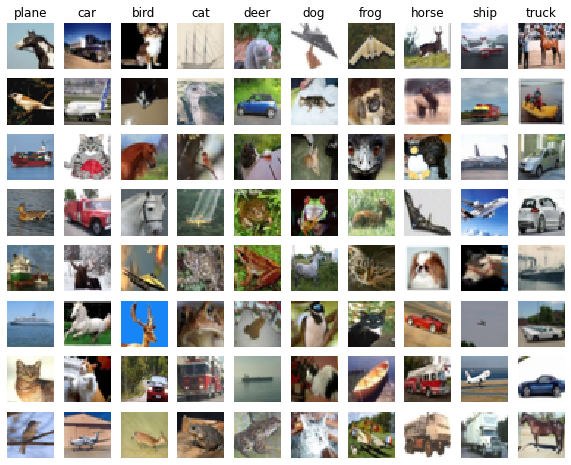

In [169]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
They make some sort of sense. This is because it either confuses it a bit, in the example of a car and a truck, or it sees a different background that usually correspond with an image. Like some blue stuff for a ship and some skies for aa plane.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print X_train_feats.shape

In [173]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

learning_rates = 10**np.random.uniform(-8, -1, size = 10)
regularization_strengths = 10**np.random.uniform(-3, 6, size = 10)
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
hs = 150
for i, lr in enumerate(learning_rates):
    for j, rs in enumerate(regularization_strengths):
        print("Current: lr:{}\trs:{}\t".format(lr, rs))
        net = TwoLayerNet()
        loss_hist = net.train(X = X_train_feats, y = y_train, learning_rate=lr, reg=rs, num_iters=1000,
            batch_size=128, verbose=False, input_size = input_dim, hidden_size = hs, output_size = num_classes)
        y_train_preds = net.predict(X_train_feats)
        y_val_preds = net.predict(X_val_feats)
        val_acc = (y_val_preds == y_val).mean()
        train_acc = (y_train_preds == y_train).mean()
        results[(lr, rs)] = (train_acc, val_acc)
        print("Current: lr:{}\trs:{}\t".format(lr, rs))
        print(i, j)
        if val_acc > best_val:
            best_val = val_acc
            best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Current: lr:0.007417177834407952	rs:0.004699615096854751	


TypeError: __init__() missing 3 required positional arguments: 'input_size', 'hidden_size', and 'output_size'

In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!